#  Проект "Прогнозирование заказов такси"

Предоставлены данные Яндекс Практикумом о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. Целевая переменная ("количество заказов") находится в столбце `num_orders`.

Размер тестовой выборки должен быть 0.1 от общей выборки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

<a name='introduction'></a>
<br>**План работы**:
1. [Подготовка данных](#1.-Подготовка-данных):
    - [Импортирование библиотек и файлов](#1.1-Импортирование-библиотек-и-файлов);
    - [Предобработка данных](#1.-2.-Предобработка-данных);
    - [Feature Engineering](#1.-3.-Feature-Engineering).
2. [Анализ данных](#2.-Анализ-данных);
3. [Обучение](#3.-Обучение):
    - [Подготовка данных к обучению](#3.-1.-Подготовка-данных-к-обучению);
    - [ML-модели](#3.-2.-ML-модели):
        - [Дерево решений](#3.-2.-1.-Дерево-решений);
        - [Случайный лес](#3.-2.-2.-Случайный-лес);
        - [Линейная регрессия](#3.-2.-3.-Линейная-регрессия);
        - [Ridge-регрессия](#3.-2.-4.-Ridge-регрессия);
        - [Lasso-регрессия](#3.-2.-5.-Lasso-регрессия);
        - [Нейронная сеть](#3.-2.-6.-Нейронная-сеть).
4. [Тестирование](#4.-Тестирование)
5. [Выводы](#5.-Выводы)

## 1. Подготовка данных
[Введение](#introduction)

### 1. 1. Импортирование библиотек и файлов
[Введение](#introduction)

In [1]:
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import torch
from torch import nn

# Загрузка файла
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

display(df_taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [2]:
# Смена типа столбца 'datetime', указание его в качестве индекса и ресемплирование по часу
df_taxi = df_taxi.resample('1H').sum()

print('Размер датасета:', df_taxi.shape)
display(df_taxi.head())

Размер датасета: (4416, 1)


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### 1. 2. Предобработка данных
[Введение](#introduction)

In [3]:
print('Количество пропущенных значений:')
df_taxi.isna().sum()

Количество пропущенных значений:


num_orders    0
dtype: int64

### 1. 3. Feature Engineering
[Введение](#introduction)

In [4]:
# Функция для создания дополнительных признаков
def add_features(data_frame, lag_num, rolling_num):
    # Календарные признаки
    df = data_frame.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    # Отстающие значения
    for lag in range(1, lag_num):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    # Скользящее среднее по определенному количеству значений 
    df[f'rolling_mean_{rolling_num}'] = df['num_orders'].shift().rolling(rolling_num).mean()
    
    return df

# Создание дополнительных признаков для существующего датафрейма
df_taxi = add_features(df_taxi, lag_num=24, rolling_num=24)
display(df_taxi.head())

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,rolling_mean_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Анализ данных
[Введение](#introduction)

Посмотрим на графики функции

In [5]:
COLORS = ['green', 'blue', 'orange', 'c', 'm', 'purple']
TITLE_FONT = 16
LABEL_FONT = 14
TICKS_FONT = 12

In [6]:
# Функция для создания графика функции
def create_plot(df, col, col_label):
    plt.figure(figsize=(15, 10))

    plt.plot(
        df.index,
        df[col],
        color=random.choice(COLORS)
    )

    plt.title('График первоначальной функции', fontsize=TITLE_FONT)
    plt.xlabel('Дата', fontsize=LABEL_FONT)
    plt.xticks(fontsize=TICKS_FONT)
    plt.ylabel(col_label, fontsize=LABEL_FONT)
    plt.yticks(fontsize=TICKS_FONT)
    plt.grid(True)
    plt.show()

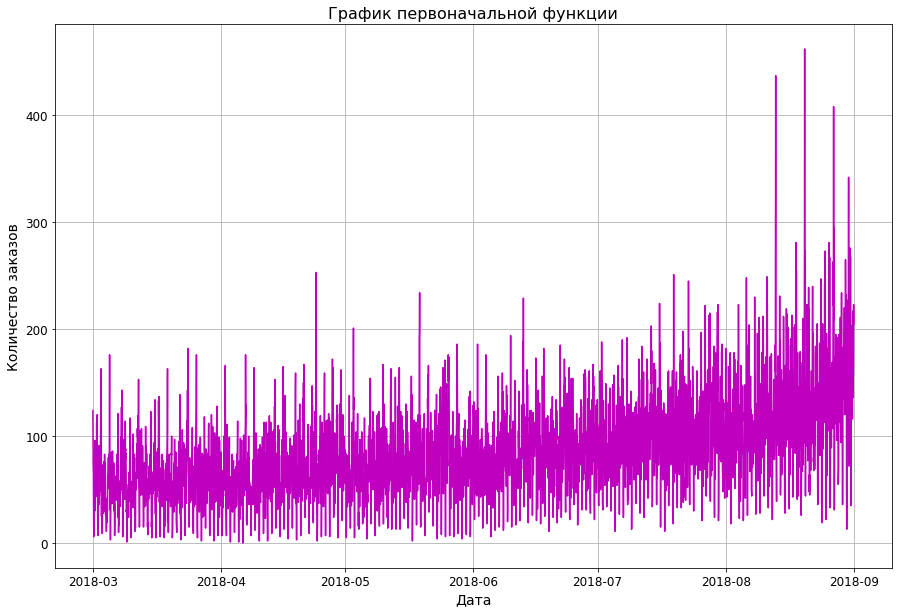

In [7]:
# Первоначальный график функции
create_plot(df_taxi, col='num_orders', col_label="Количество заказов")

Волатильность колебаний довольно высока - значения могут варьироваться от почти 0 до около 450 в час. Однако наблюдается повышательный тренд и постепенное увеличение количества заказов с марта до сентября 2018 года.

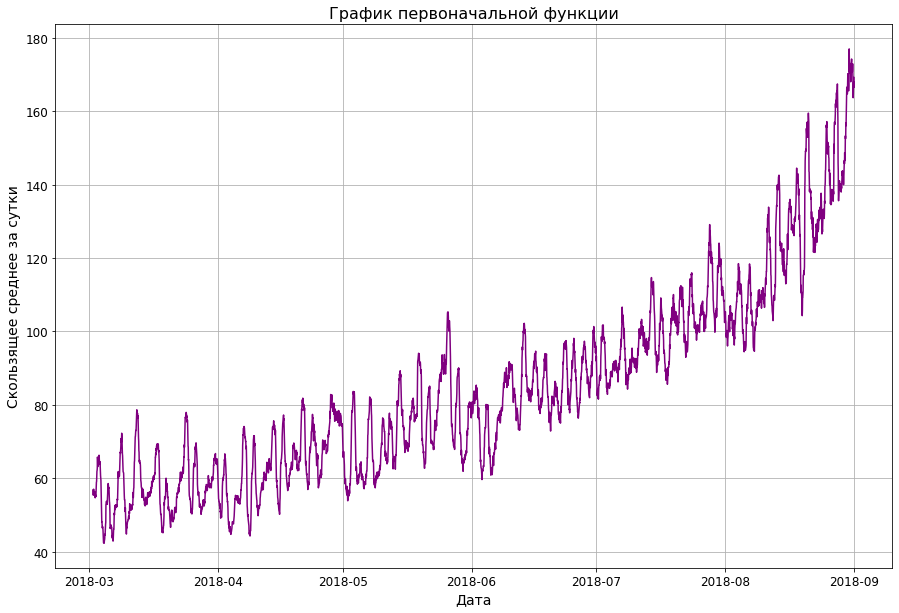

In [8]:
pd.options.mode.chained_assignment = None

# График со скользящим средним за сутки
create_plot(df_taxi, col='rolling_mean_24', col_label='Скользящее среднее за сутки')

На втором графике отчетливо наблюдается повышательная тенденция, демонстрирующая увеличение объема заказов за одни сутки. Данный показатель увеличился с около 50 в марте 2018-го года до более 160 к сентябрю 2018-го года.

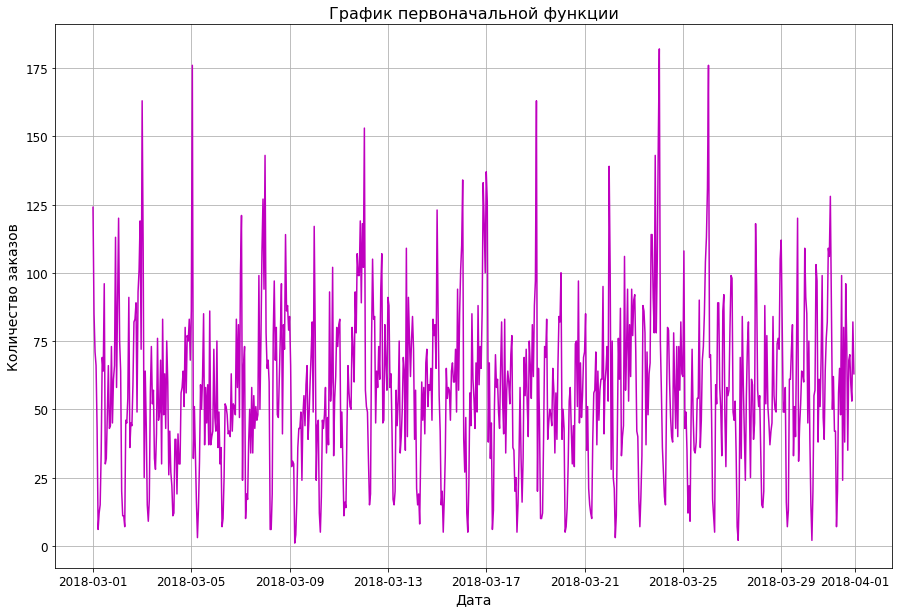

In [9]:
# Рассмотрим количество заказов за март
df_taxi_march = df_taxi['2018.03.01':'2018.03.31']

create_plot(df_taxi_march, 'num_orders', "Количество заказов")

Можно заметить, что в рассмотренный период временной ряд довольно стационарен. Наблюдаются также довольно большие колебания значений: от едва более 0 до более чем 175.

Посмотрим далее на тренд и сезонность по имеющемуся набору данных.

Для определения сезонности рассмотрим недельный интервал (с 1 по 8 марта).

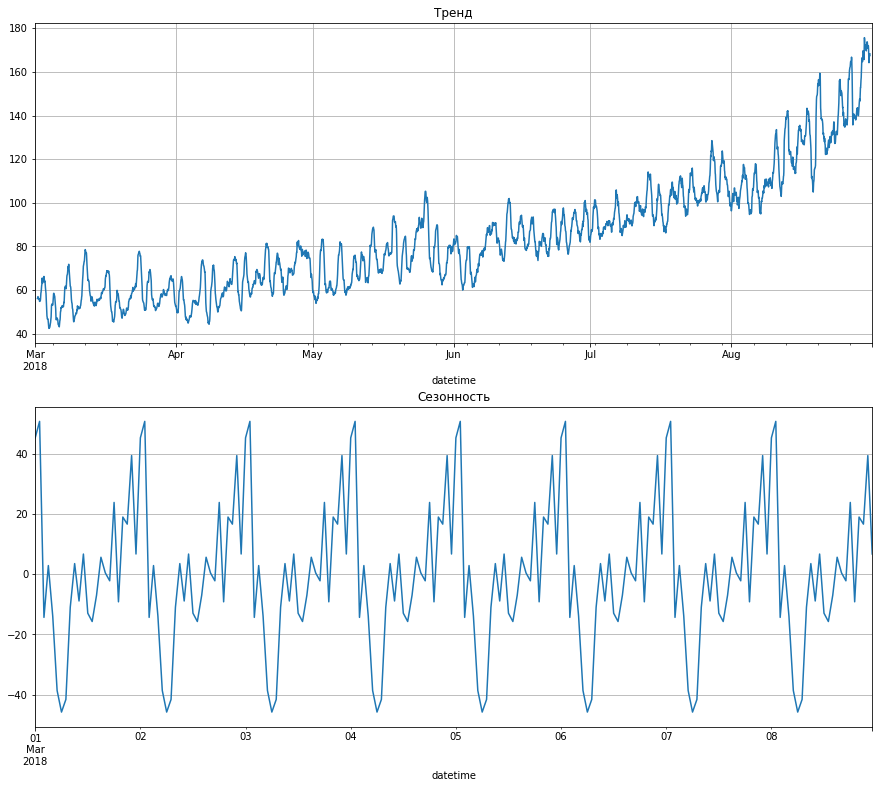

In [11]:
# Рассмотрим тренд на всем графике
decomposed = seasonal_decompose(df_taxi['num_orders'])

plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.trend.plot(title='Тренд', ax=plt.gca())
plt.grid(True)

# Рассмотрим сезонность на недельном интервале
week_df = df_taxi['2018.03.01':'2018.03.08']

decomposed_week = seasonal_decompose(week_df['num_orders'])

plt.subplot(312)
decomposed_week.seasonal.plot(title='Сезонность', ax=plt.gca())
plt.grid()

plt.show()

**Выводы**:

Можно заметить, что наблюдается повышательный тренд на протяжении всего рассматриваемого периода (с марта по сентябрь 2018 года). Более того значение количества заказов увеличилось с около 50 в марте до примерно 170 к сентябрю 2018-го года - темп роста более, чем в три раза!

Для определения сезонности взят интервал в одну неделю. Можно заметить, что в зависимости от часа сильно зависит и общее количество заказов. Тем не менее, важно отметить, что цикличность (а в случае временных рядов это сезонность) в данном случае составляет одни сутки.

Посмотрим, имеются ли полные дубликаты в датасете, от которых можно избавиться.

In [12]:
df_taxi.duplicated().sum()

0

In [13]:
# Общая информация по получившемуся датафрейму
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4416 non-null   int64  
 1   month            4416 non-null   int64  
 2   day              4416 non-null   int64  
 3   dayofweek        4416 non-null   int64  
 4   lag_1            4415 non-null   float64
 5   lag_2            4414 non-null   float64
 6   lag_3            4413 non-null   float64
 7   lag_4            4412 non-null   float64
 8   lag_5            4411 non-null   float64
 9   lag_6            4410 non-null   float64
 10  lag_7            4409 non-null   float64
 11  lag_8            4408 non-null   float64
 12  lag_9            4407 non-null   float64
 13  lag_10           4406 non-null   float64
 14  lag_11           4405 non-null   float64
 15  lag_12           4404 non-null   float64
 16  lag_13          

## 3. Обучение
[Введение](#introduction)

Разобьем данные на тренировочную и тестовую выборки. Далее избавимся от пропущенных значений и начнем осуществлять обучение моделей машинного обучения.

### 3. 1. Подготовка данных к обучению
[Введение](#introduction)

В подготоку данных к обучению включается:
- Разделение выборок на тренировочную и тестовую;
- Масштабирование количественных признаком (в даннмо случае - всех).

In [14]:
# Разделение данных на тренировочную и тестовую выборки
train, test = train_test_split(
    df_taxi,
    shuffle=False,
    test_size=0.1
)

# Удаление пропущенных значений
train = train.dropna()

# Тренировочная выборка
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

# Тестовая выборка
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# Масштабирование
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 3. 2. ML-модели
[Введение](#introduction)

Создание моделей машинного обучения для решения поставленной задачи - прогнозирования значения количества заказов - num_orders.

<br>**ML-модели**:
1. [Дерево решений](#3.-2.-1.-Дерево-решений);
2. [Случайный лес](#3.-2.-2.-Случайный-лес);
3. [Линейная регрессия](#3.-2.-3.-Линейная-регрессия);
4. [Ridge-регрессия](#3.-2.-4.-Ridge-регрессия);
5. [Lasso-регрессия](#3.-2.-5.-Lasso-регрессия);
6. [Нейронная сеть](#3.-2.-6.-Нейронная-сеть).

In [15]:
# Получение RMSE у лучшей модели
def get_best_parameters(model):
    ts = TimeSeriesSplit()
    
    # Перебор гиперпараметров
    grid = GridSearchCV(model, param_grid, cv=ts, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)

    print(grid.best_estimator_)

    # Поскольку GridSearchCV работает на максимизацию метрики, то использовается инвентированное значение RMSE
    print('RMSE:', round(grid.best_score_ * -1, 3))

#### 3. 2. 1. Дерево решений
[Введение](#introduction)

<br>Гиперпараметры для перебора:
- max_depth:
    - от 10 до 21. Шаг - 2.
- max_features:
    - None | log2 | sqrt.

In [16]:
tree = DecisionTreeRegressor(random_state=42)

# Гиперпараметры для перебора
param_grid = {
    'max_depth': range(10, 21, 2), 
    'max_features': [None, 'log2', 'sqrt']
}

get_best_parameters(tree)

DecisionTreeRegressor(max_depth=10, random_state=42)
RMSE: 32.493


*DecisionTreeRegressor(max_depth=10, random_state=42)*

    RMSE: 35.4

#### 3. 2. 2. Случайный лес
[Введение](#introduction)

<br>Гиперпараметры для перебора:
- max_depth:
    - от 10 до 21. Шаг - 2.
- n_estimators:
    - от 150 до 351. Шаг - 50.

In [17]:
'''
%%time

forest = RandomForestRegressor(random_state=42)

# Гиперпараметры для перебора
param_grid = {
    'max_depth': range(10, 21, 2), 
    'n_estimators': range(150, 351, 50)
}

get_best_parameters(forest)
'''

"\n%%time\n\nforest = RandomForestRegressor(random_state=42)\n\n# Гиперпараметры для перебора\nparam_grid = {\n    'max_depth': range(10, 21, 2), \n    'n_estimators': range(150, 351, 50)\n}\n\nget_best_parameters(forest)\n"

*RandomForestRegressor(max_depth=12, n_estimators=350, random_state=42)*

RMSE: 28.563

CPU times: user 12min 25s, sys: 2.68 s, total: 12min 28s
Wall time: 12min 30s

#### 3. 2. 3. Линейная регрессия
[Введение](#introduction)

In [18]:
linear = LinearRegression()

linear.fit(X_train, y_train)
linear_pred_train = linear.predict(X_train)

linear_train_rmse = np.sqrt(mean_squared_error(y_train, linear_pred_train))
print(linear)
print('\tRMSE:', round(linear_train_rmse, 3))

LinearRegression()
	RMSE: 25.819


#### 3. 2. 4. Ridge-регрессия
[Введение](#introduction)

<br>Гиперпараметры для перебора:
- alpha:
    - 0.01 | 0.1 | 1 | 10 | 20

In [19]:
ridge = Ridge(random_state=42)

param_grid = {
    'alpha': [0.1, 1, 10, 20, 30, 40]
}

get_best_parameters(ridge)

Ridge(alpha=0.1, random_state=42)
RMSE: 27.057


#### 3. 2. 5. Lasso-регрессия
[Введение](#introduction)

In [20]:
lasso = Lasso(random_state=42)

param_grid = {
    'alpha': [0.1, 1, 10, 20, 30, 40]
}

get_best_parameters(lasso)

Lasso(alpha=0.1, random_state=42)
RMSE: 27.965


#### 3. 2. 6. Нейронная сеть
[Введение](#introduction)

<br>Архитектура нейронной сети:
- 4 слоя - 2 скрытых:
    - Входной слой: количество нейронов - число независимых параметров по обучающей выборке;
    - Скрытый слой №1: 10 нейронов;
    - Скрытый слой №2: 5 нейронов;
    - Выходной слой: 1 нейрон.
- Функции активации - LeakyReLU (поскольку задача регрессии);
- Количество эпох - 51;
- Тестирование модели - каждые 10 эпохи;
- Остановка модели, если значение RMSE меньше 48 (необходимо по заданию);
- Инициализация весов по непрерывному равномерному распределению Кайминга;
- Осуществление тренировки с помощью батчей;
- Размер батча - 128;
- Осуществление номрализации батчей с помощью BatchNorm1d;
- Оптимизатор - Adam. Скорость обучения - 5e-3;
- Функция потерь и метрика - RMSE.

Работа с нейронной сетью:
- Подготовка к работе нейронной сети - установление Random Seed, конвертация тренировочной и тестовой выборок в Tensor;
- Создание нейройнной сети в соответствии с определенной ранее архитектурой;
- Инициализация весов нейронной сети;
- Тренировка нейройнной сети с использованием батчей.

In [21]:
# Установка random seed
torch.manual_seed(42)
np.random.seed(42)

X_train_torch = torch.FloatTensor(X_train)
X_test_torch = torch.FloatTensor(X_test)
y_train_torch = torch.FloatTensor(y_train.values)
y_test_torch = torch.FloatTensor(y_test.values)

# Число нейронов в каждом слое
in_neurons = X_train.shape[1]
hidden_neurons_1 = 10
hidden_neurons_2 = 5
out_neurons = 1

# Нейронная сеть
net = nn.Sequential(
    nn.Linear(in_neurons, hidden_neurons_1),
    nn.BatchNorm1d(hidden_neurons_1),
    nn.LeakyReLU(),
    nn.Linear(hidden_neurons_1, hidden_neurons_2),
    nn.BatchNorm1d(hidden_neurons_2),
    nn.LeakyReLU(),
    nn.Linear(hidden_neurons_2, out_neurons),
    nn.LeakyReLU()
)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
loss = nn.MSELoss()

In [22]:
# Функция для инициализации весов нейросети
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='leaky_relu'
        )

# Инициализация весов нейросети
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=27, out_features=10, bias=True)
  (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=10, out_features=5, bias=True)
  (4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=5, out_features=1, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)

In [23]:
%%time

# Количество эпох, размер одного батча и их количество
num_epochs = 51
batch_size = 128
num_batches = ceil(len(X_train_torch) / batch_size)

# Обучение нейросети
for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train_torch))
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size

        optimizer.zero_grad()

        batch_indexes = order[start_idx:start_idx + batch_size]
        X_batch = X_train_torch[batch_indexes]
        y_batch = y_train_torch[batch_indexes]

        # Обучение нейросети
        preds = net.forward(X_batch).flatten()

        loss_value = torch.sqrt(loss(preds, y_batch))
        loss_value.backward()

        optimizer.step()


print('RMSE на тренировочной выборке из 128 случайных объектов:', round(loss_value.item(), 3), '\n')

RMSE на тренировочной выборке из 128 случайных объектов: 27.347 

CPU times: user 9.05 s, sys: 0 ns, total: 9.05 s
Wall time: 9.08 s


## 4. Тестирование
[Введение](#introduction)

Получается, что наилучшее значение на тренировочной выборке продемонстрировала Нейронная сеть. Осуществим тестировани данной модели на тестовой выборке.

In [24]:
net.eval()
net_test_preds = net.forward(X_test_torch).flatten()
nn_rmse = round(torch.sqrt(loss(net_test_preds, y_test_torch)).item(), 3)

print('Нейронная сеть:')
print(net)
print('\tRMSE =', nn_rmse)

Нейронная сеть:
Sequential(
  (0): Linear(in_features=27, out_features=10, bias=True)
  (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=10, out_features=5, bias=True)
  (4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=5, out_features=1, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
	RMSE = 43.132


## 5. Выводы
[Введение](#introduction)

Согласно проведенному тестированию наилучшей моделью по метрике RMSE стала Нейронная сеть с параметрами по [ссылке](#3.-2.-6.-Нейронная-сеть). Значение RMSE составило 43.132, что удовлетворяет необходимому условию задачи: RMSE должно быть не более 48.

Далее выведем график "Факт-Прогноз" по данному модели для первых 24 объектов (первых суток) тестовой выборки.

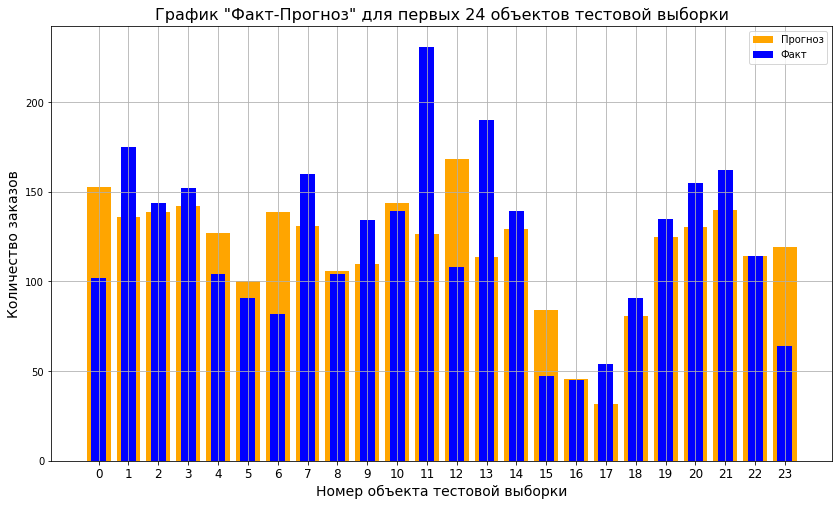

In [25]:
# Создание графика "Факт-Прогноз" для 24-х первых объектов тестовой выборки
plt.figure(figsize=(14, 8))

plt.bar(range(0, 24), net_test_preds[0:24].detach().numpy(), color='orange', label='Прогноз')
plt.bar(range(0, 24), y_test[0:24], width=0.5, color='blue', label='Факт')

plt.title('График "Факт-Прогноз" для первых 24 объектов тестовой выборки', fontsize=16)
plt.xlabel('Номер объекта тестовой выборки', fontsize=14)
plt.xticks(range(0, 24), fontsize=12)
plt.ylabel('Количество заказов', fontsize=14)
plt.xticks(fontsize=12)
plt.grid()
plt.legend()
plt.show()

Стоит отметить, что во многих случаях реальное значение количества заказов за час не сильно отличается от предсказанного моделью нейронной сети, но бывают и исключения.

Далее также рассмотрим важность признаков.

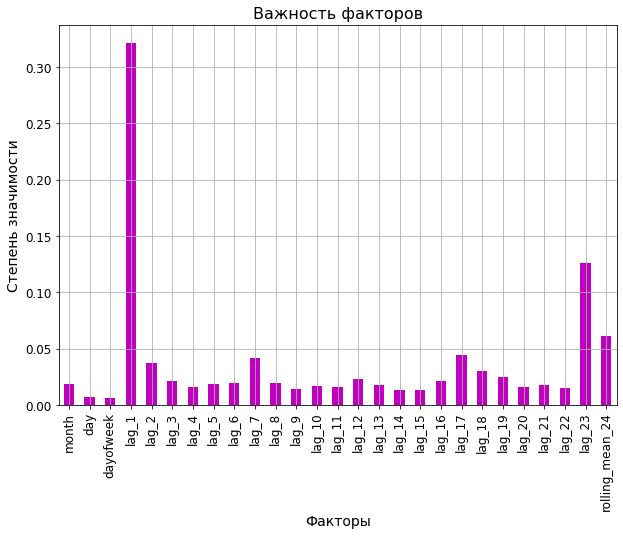

In [26]:
# Получение графика важности признаков
forest = RandomForestRegressor(max_depth=12, n_estimators=350, random_state=42)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
forest_importances = pd.Series(importances, df_taxi.drop('num_orders', axis=1).columns.values)

plt.figure(figsize=(10, 7))

forest_importances.plot(kind='bar', grid=True, color='m')

plt.title('Важность факторов', fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel('Факторы', fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Степень значимости', fontsize=14)
plt.show()

На графике отчетливо видно, что смещение результатов на единицу наибольшим образом влияет на предсказание моделей. Коэффициент степени значимости данного признака превышает 0.3, когда иных параметров степень важности менее 0.15.

**Рекомендация**:

Для определения количества заказов по часам следует использовать нейронную сеть с [описанной ранее архитектурой](#Нейронная-сеть), так как ее значение RMSE наибольшим образом удовлетворяет поставленной задачи - значение RMSE должно быть менее 48 - и составляет около 43. 